In [1]:
from google.colab import files
u = files.upload()

Saving test.csv.zip to test.csv.zip
Saving train.csv.zip to train.csv.zip


In [2]:
import numpy as np 
import pandas as pd 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from lightgbm import LGBMClassifier

import random

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

train_data = pd.read_csv("train.csv.zip")
test_data = pd.read_csv("test.csv.zip")

In [7]:
train_data.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [4]:
train_data.isna().sum()

id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
type             0
dtype: int64

In [6]:
train_data.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


# Data Preparation
**Let’s prepare the tarin_data for the LightGBM classifier. I will change the type of the categorical column from colour, and also change the target column, “type”, to full. The color column is nominal, so we’ll be using hot encoding, but in pandas, there is the “get_dummies” function which is very useful, easy to use, and does the same with hot encoding**

In [8]:
train_data = pd.get_dummies(train_data, columns=["color"], prefix=["color"])
map_type = {"Ghoul":1, "Goblin":2, "Ghost":0} # change ghoul, goblin, ghost to 1, 2 and 0
train_data.loc[:, "type"] = train_data.type.map(map_type)

train_data = train_data.set_index('id')

In [9]:
train_data

,bone_length,rotting_flesh,hair_length,has_soul,type,color_black,color_blood,color_blue,color_clear,color_green,color_white
id,,,,,,,,,,,
0,0.354512,0.350839,0.465761,0.781142,1,0,0,0,1,0,0
1,0.575560,0.425868,0.531401,0.439899,2,0,0,0,0,1,0
2,0.467875,0.354330,0.811616,0.791225,1,1,0,0,0,0,0
4,0.776652,0.508723,0.636766,0.884464,1,1,0,0,0,0,0
5,0.566117,0.875862,0.418594,0.636438,0,0,0,0,0,1,0
7,0.405680,0.253277,0.441420,0.280324,2,0,0,0,0,1,0
8,0.399331,0.568952,0.618391,0.467901,2,0,0,0,0,0,1
11,0.516224,0.536429,0.612776,0.468048,1,0,0,0,1,0,0
12,0.314295,0.671280,0.417267,0.227548,0,0,0,1,0,0,0


In [17]:
X = train_data.drop(["type"],axis=1)
y = train_data.type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

**First of all, we need to define the parameters and intervals. The parameters must be defined in a dictionary. The LightGBM classification model will try all the intervals we have set and try to find the optimal settings to get the best score.**

In [11]:
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': [0.01,0.1,0.5],
    'subsample_for_bin': [20000,50000,100000,120000,150000],
    'min_child_samples': [20,50,100,200,500],
    'colsample_bytree': [0.6,0.8,1],
    "max_depth": [5,10,50,100]
}

In [12]:
lgbm = LGBMClassifier() 
lgbm.fit(X_train, y_train) 

LGBMClassifier()

In [13]:
lgbm_tuned = LGBMClassifier(boosting_type = 'gbdt',
                            class_weight = None,
                            min_child_samples = 20,
                            num_leaves = 30,
                            subsample_for_bin = 20000,
                            learning_rate=0.01, 
                            max_depth=10, 
                            n_estimators=40, 
                            colsample_bytree=0.6) # LightGBM Classifier with optimum paramteres
lgbm_tuned.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.01, max_depth=10,
               n_estimators=40, num_leaves=30, subsample_for_bin=20000)

In [18]:
y_test_pred = lgbm_tuned.predict(X_test) #Predicting X_test to find the solutiın
score = round(accuracy_score(y_test, y_test_pred), 3) # Find the accuracy of y_test and predicitons, and round the result
print(score)

0.691


**Let’s take a look at which features the model has given more importance**

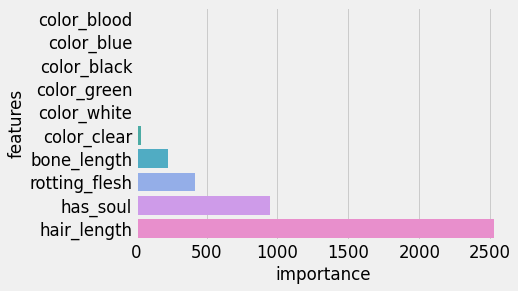

In [19]:
sns.set_context("talk")
style.use('fivethirtyeight')

fi = pd.DataFrame()
fi['features'] = X.columns.values.tolist()
fi['importance'] = lgbm_tuned.booster_.feature_importance(importance_type='gain')

sns.barplot(x='importance', y='features', data=fi.sort_values(by='importance', ascending=True))